# Reprotrack interactive session - Travel mode split

Travel mode choices are formed due to the everyday needs and constraints
 of individuals and are influenced by travel-related factors such as 
cost, time, accessibility, and comfort. It is, therefore, not uncommon 
for mobility systems to be evaluated and compared based on the current 
modal splits of the overall population. Trackintel provides a series of 
travel mode related functions to assist in mode analysis of individual movement. 



### Import dependencies and libraries

In [3]:
import os
import json
import pickle as pickle

import geopandas as gpd
import pandas as pd
import numpy as np

# for fetching osm data
import osmnx as ox

# for visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# trackintel -> the functions will be imported with full names
import trackintel as ti


In [4]:
# options for better printing and visualizing

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

matplotlib.rcParams["figure.dpi"] = 300
matplotlib.rcParams["xtick.labelsize"] = 13
matplotlib.rcParams["ytick.labelsize"] = 13
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

%matplotlib inline

In [5]:
# get the data dir from the config file -> default stored in Data/Geolife/Data folder

DATA_DIR = os.path.join("..", "paths.json")
with open(DATA_DIR) as json_file:
    CONFIG = json.load(json_file)

save_dir = os.path.join("..", CONFIG["data_dir"])

# Load Geolife data
You can use your own dataset (see instructions below), or work with the Geolife dataset. In the latter case, Trackintel provides a function [read_geolife](https://trackintel.readthedocs.io/en/latest/modules/io.html#trackintel.io.read_geolife) to directly load [Geolife](https://www.microsoft.com/en-us/research/publication/geolife-gps-trajectory-dataset-user-guide/) dataset into the trackintel positionfixes. For the tutorial and interactive section, we provided you a sample dataset with 20 selected users from the geolife dataset. This can be directly loaded from the `save_dir`. 

In [6]:

pfs, mode_labels = ti.io.read_geolife(save_dir, print_progress=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.09it/s]


## Reading your own data
Trackintel provides an I/O module for accessing movement data and storing intermediate or final results in a file or database. Three methods for converting movement data with attached attribute information to Trackintel-compatible formats are provided:
1) reading from Pandas Dataframes and Geopandas Geodataframes (**recommended**)
2) reading and writing from CSV file formats
3) reading and storing from PostgreSQL databases with PostGIS extension. Check the [input/output](https://trackintel.readthedocs.io/en/latest/modules/io.html) module for more information. 

An important consideration before loading data is to find the appropriate movement level for your data. Depending on the semantics of the data, you should call different reading functions, e.g., [read_positionfixes_csv](https://trackintel.readthedocs.io/en/latest/modules/io.html#trackintel.io.read_positionfixes_csv) or [read_staypoints_csv](https://trackintel.readthedocs.io/en/latest/modules/io.html#trackintel.io.read_staypoints_csv). We provide a reference of the different data types in the figure below:

![Trackintel data support](prepare/trackintel_structure.png)

In [7]:
# TODO: use ti.read_positionfixes_csv() or ti.read_staypoints_csv() for loading your data. Check the documentation for the required input parameters
# selected_pfs = ti.read_positionfixes_csv()

### Task 1: Generate triplegs

To compute a mode split, we first need to generate triplegs. For some datasets, you might have triplegs already and can load them directly with `ti.read_triplegs_csv`. Otherwise, we need to generate them with the `generate_staypoints` and `generate_triplegs` functions in Trackintel:


In [8]:
# SOLUTION
pfs, sp = pfs.generate_staypoints(method='sliding', dist_threshold=100, time_threshold=5.0, include_last=False, print_progress=True)
pfs, tpls = pfs.generate_triplegs(sp, method='between_staypoints', gap_threshold=15)

/Users/ninawiedemann/MIE/trackintel/trackintel/preprocessing/positionfixes.py:113: UserWarning: 1690 duplicates were dropped from your positionfixes. Dropping duplicates is recommended but can be prevented using the 'exclude_duplicate_pfs' flag.
  warnings.warn(warn_str)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:39<00:00,  1.97s/it]
/Users/ninawiedemann/MIE/trackintel/trackintel/preprocessing/positionfixes.py:508: UserWarning: The positionfixes with ids [3008966 3008967 3042627 3042628 3009520 3009521 2958602 2958603  148243
  148244 3660924 3660925 3840312 3840313 3840622 3840623 3773600 3773601
 3845106 3845107 3726748 3726749 3828792 3828793 3995920 3995921 3855986
 3855987 3913794 3913795 3169442 3169443 4370609 4370610 4342368 4342369
 4319198 4319199] lead to invalid tripleg geometries. The resulting triplegs were omitted and the tripleg id of the positionfixes was set to nan
  warnings.warn(warn_string)


## Task 2: Add existing mode labels

If the transport mode is known in your dataset, we want to add this information to the triplegs GeoDataFrame with the attribute name `mode`. For Geolife, the labels can be attached using the Trackintel function [geolife_add_modes_to_triplegs](https://trackintel.readthedocs.io/en/latest/modules/io.html#trackintel.io.geolife_add_modes_to_triplegs). If you check out the documentation of the [read_geolife](https://trackintel.readthedocs.io/en/latest/modules/io.html#trackintel.io.read_geolife) function that we used above, you can see that this function returns a dictionary `mode_labels`. This dictionary can be used in the `geolife_add_to_triplegs` function.


In [9]:
# SOLUTION
tpls = ti.io.geolife_add_modes_to_triplegs(tpls, mode_labels)


## Task 3: Check for missing values

In Geolife, some triplegs have labelled modes, but many are still unknown. Print the ratio of missing values in the `mode` column (if there are no mode labels available for your dataset, this would be 100%).

In [10]:
# SOLUTION:
print(f"{pd.isna(tpls['mode']).sum() / len(tpls) * 100}% of the triplegs have no mode label")

96.01050890337646% of the triplegs have no mode label


## Task 4: Impute missing values

We now want to use the Trackintel function [predict_transport_mode](geolife_add_modes_to_triplegs) to impute missing mode labels. This function is simply based on the average speed of a tripleg. Use the function to create predicted modes for all triplegs, and fill the missing values with these predicted modes.

In [11]:
# SOLUTIONS
tpls_with_predicted_mode = ti.analysis.predict_transport_mode(tpls)
tpls["pred_mode"] = tpls_with_predicted_mode["mode"]
tpls.loc[tpls["mode"].isna(), "mode"] = tpls.loc[tpls["mode"].isna(), "pred_mode"]
tpls.drop(columns={"pred_mode"}, inplace=True)

## Task 5: Align mode labels

You may have noted that the predicted modes have three categories: "slow", "motorized", and "fast". This is not comparable to the original Geolife categories (or the categories available in your own dataset). Use the following dictionary to rename the modes, such that all of them are one of "slow", "motorized", and "fast". Then count the number of triplegs per category.

In [12]:
mode_to_category = {
    "fast_mobility": "fast",
    "car": "motorized",
    "bus": "motorized",
    "taxi": "motorized",
    "ecar": "motorized",
    "motorized_mobility": "motorized",
    "bike": "slow",
    "walk": "slow",
    "slow_mobility": "slow",
}

# SOLUTION:
tpls["mode"] = tpls["mode"].map(mode_to_category)
tpls.dropna(subset=["mode"], inplace=True)
tpls["mode"].value_counts()

mode
slow         7167
motorized    3017
fast           89
Name: count, dtype: int64

## Task 6: Compute the modal split

Use the function [calculate_modal_split](https://trackintel.readthedocs.io/en/latest/modules/analysis.html#trackintel.analysis.calculate_modal_split) to compute the model split by count, distance or duration. Aggregate the data per month. Check out the other parameters of the function; for example, the modal split can be provided in absolute values or relative (`norm=True`).

Then, plot the modal split via the [plot_modal_split](https://trackintel.readthedocs.io/en/latest/modules/visualization.html#trackintel.plot_modal_split) function. 

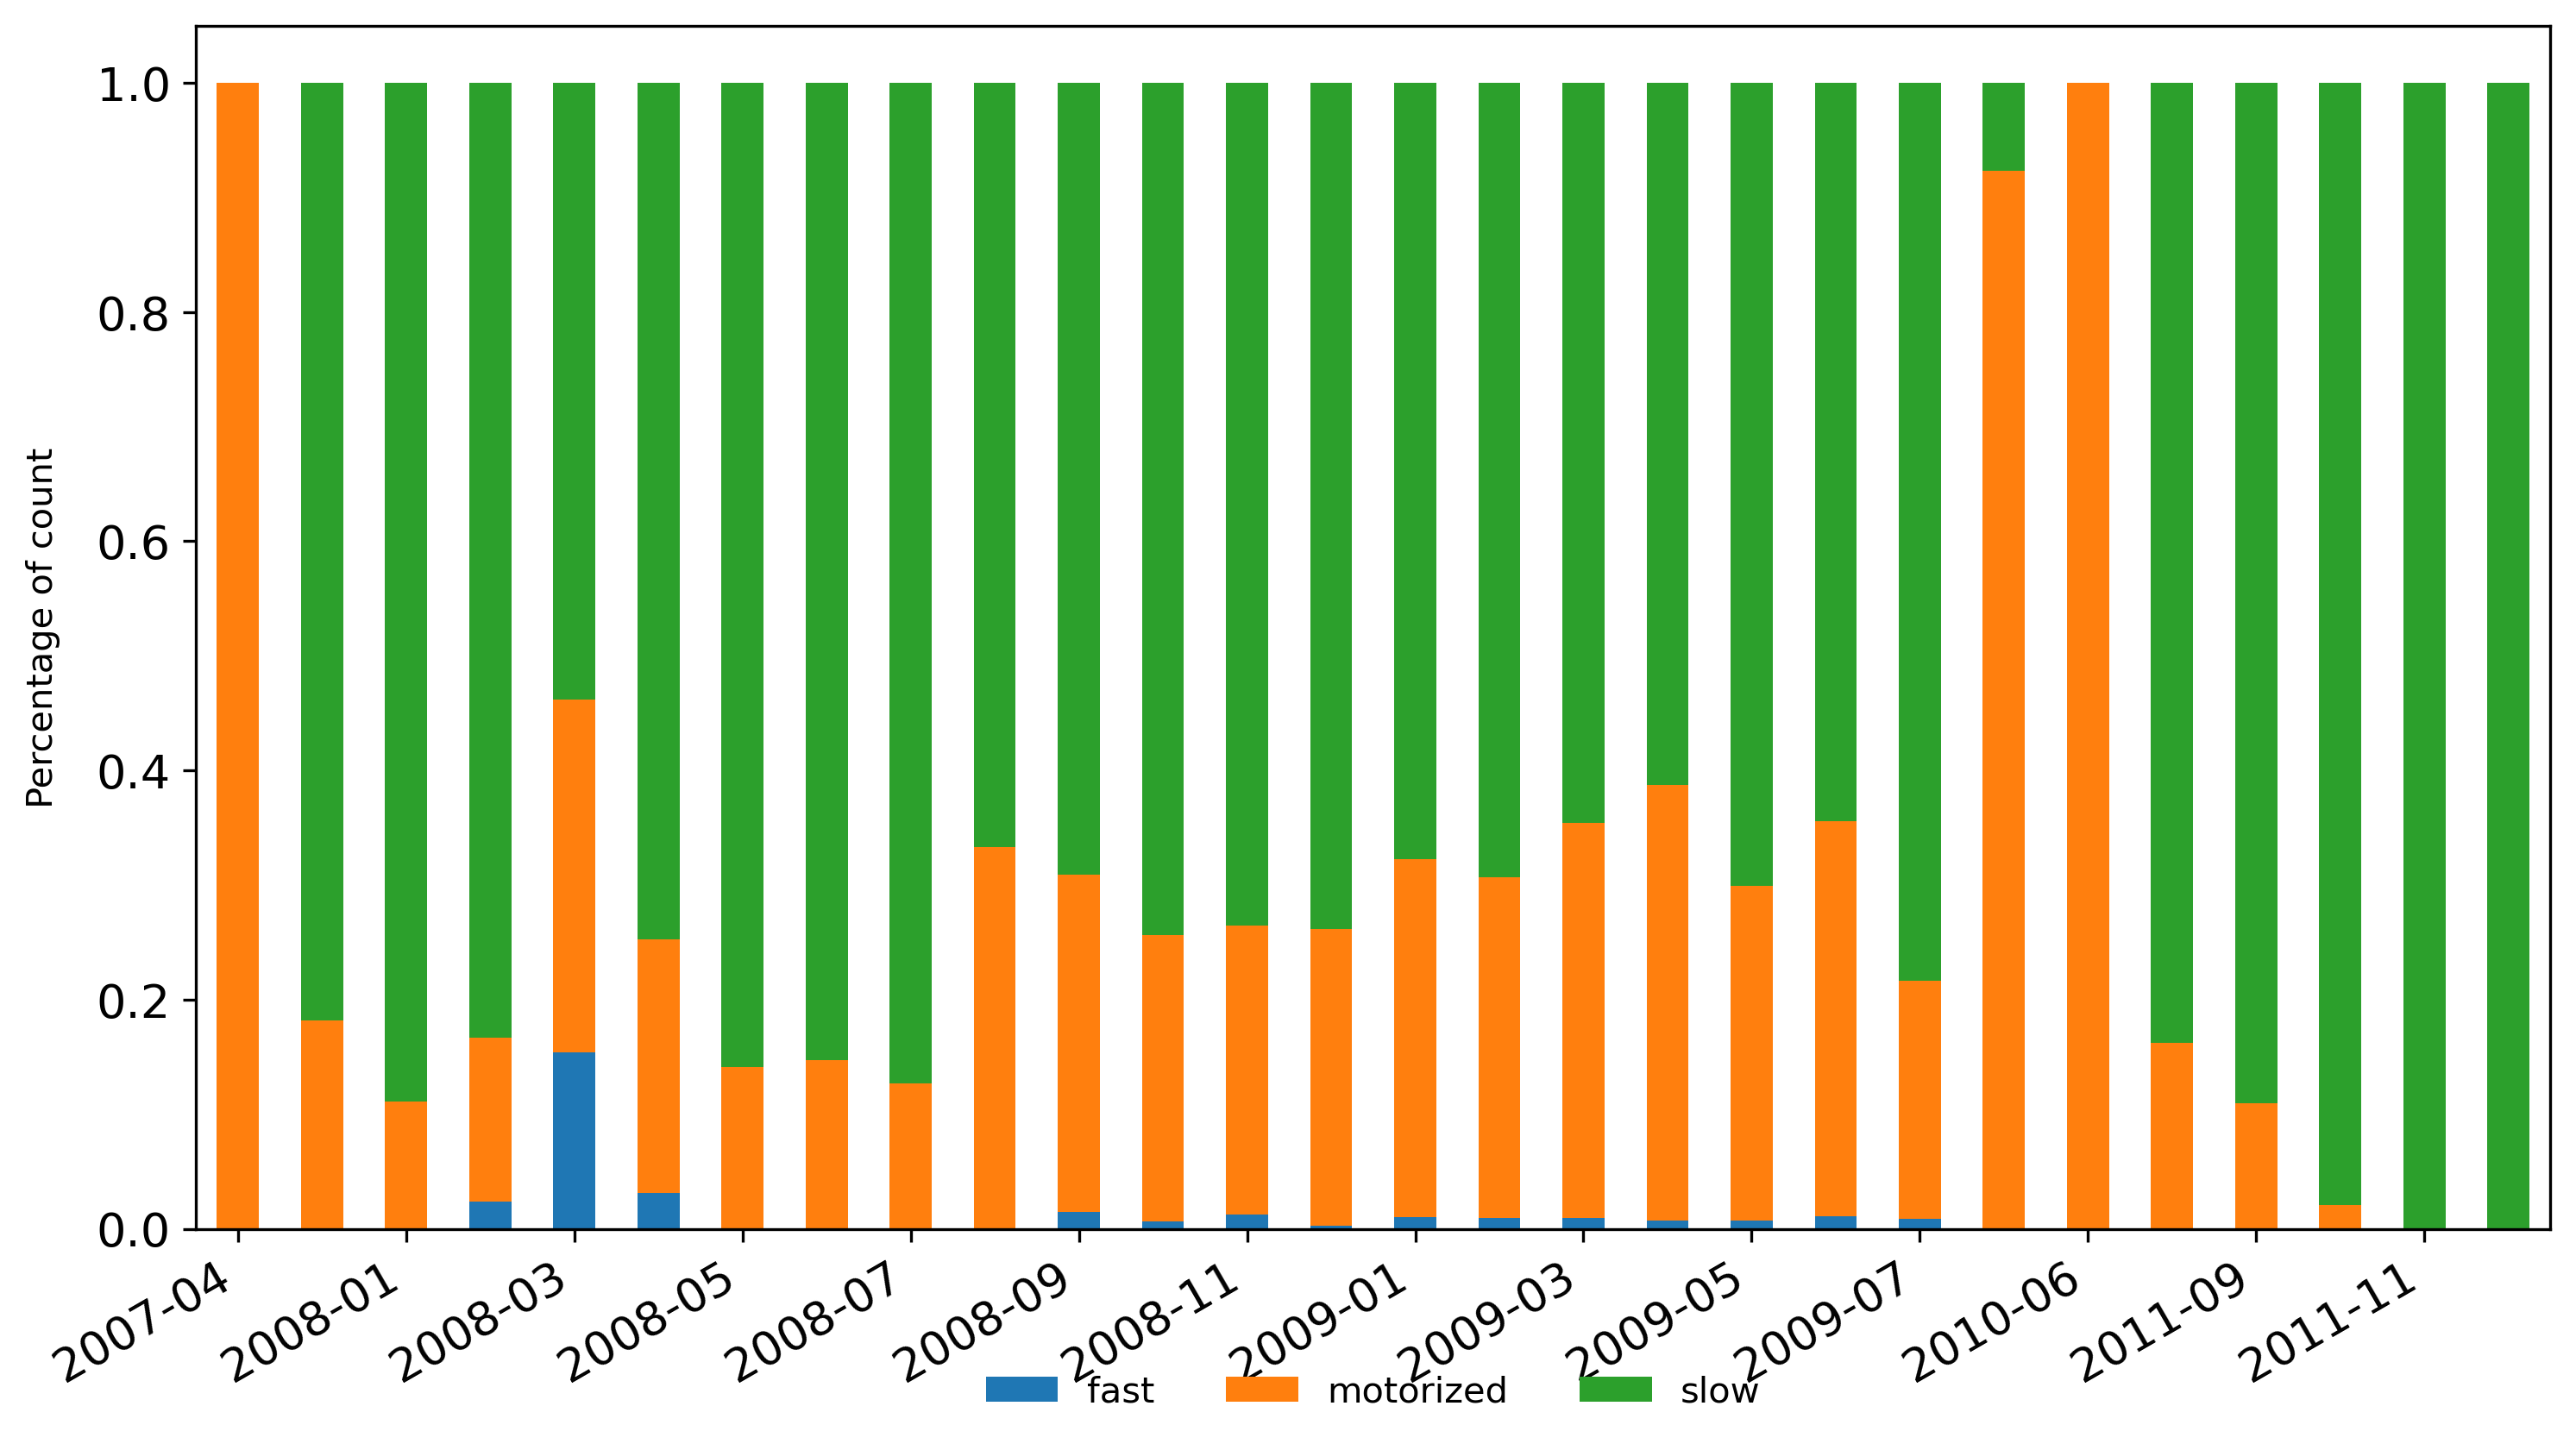

In [13]:
# SOLUTION: 
# count
modal_split_count = ti.analysis.calculate_modal_split(tpls, freq="M", metric="count", per_user=False, norm=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax = ti.plot_modal_split(
    modal_split_count,
    date_fmt_x_axis="%Y-%m",
    y_label="Percentage of count",
    skip_xticks=2,
    n_col_legend=4,
    fig=fig,
    axis=ax,
    borderaxespad=2,
)
fig.autofmt_xdate()

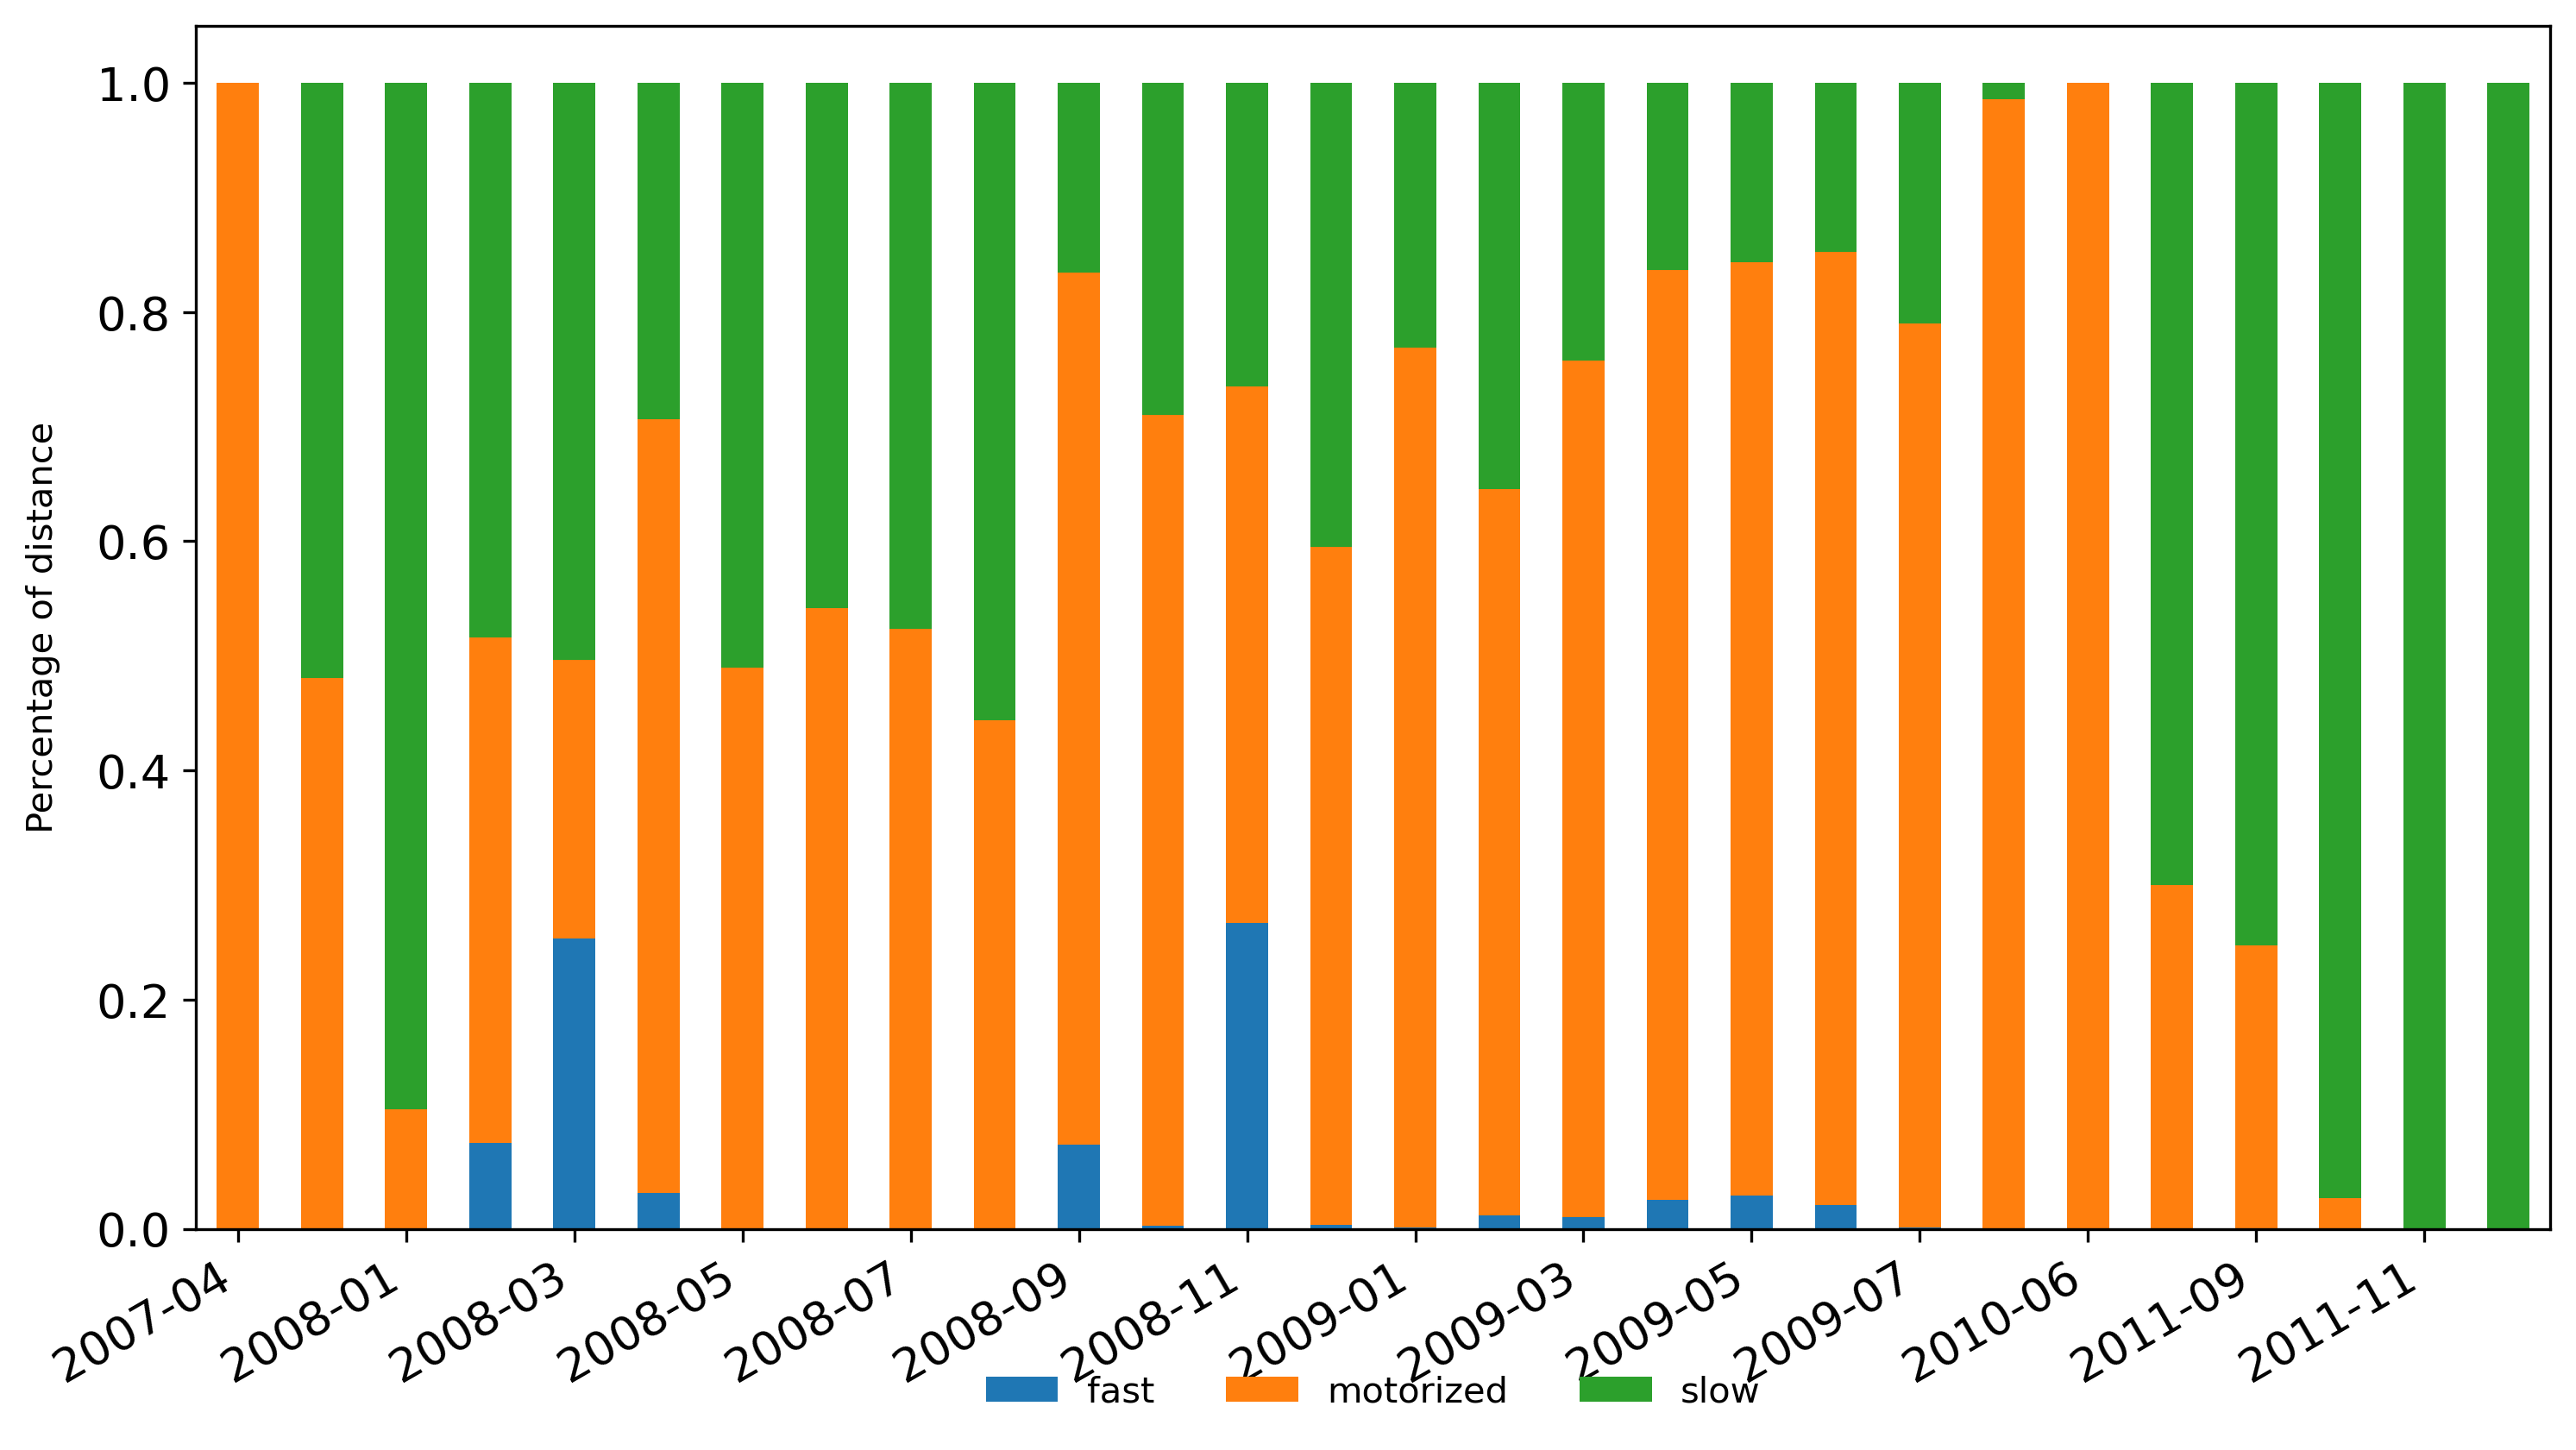

In [14]:
# distance
modal_split_distance = ti.analysis.calculate_modal_split(tpls, freq="M", metric="distance", per_user=False, norm=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax = ti.plot_modal_split(
    modal_split_distance,
    date_fmt_x_axis="%Y-%m",
    y_label="Percentage of distance",
    skip_xticks=2,
    n_col_legend=4,
    fig=fig,
    axis=ax,
    borderaxespad=2,
)
fig.autofmt_xdate()

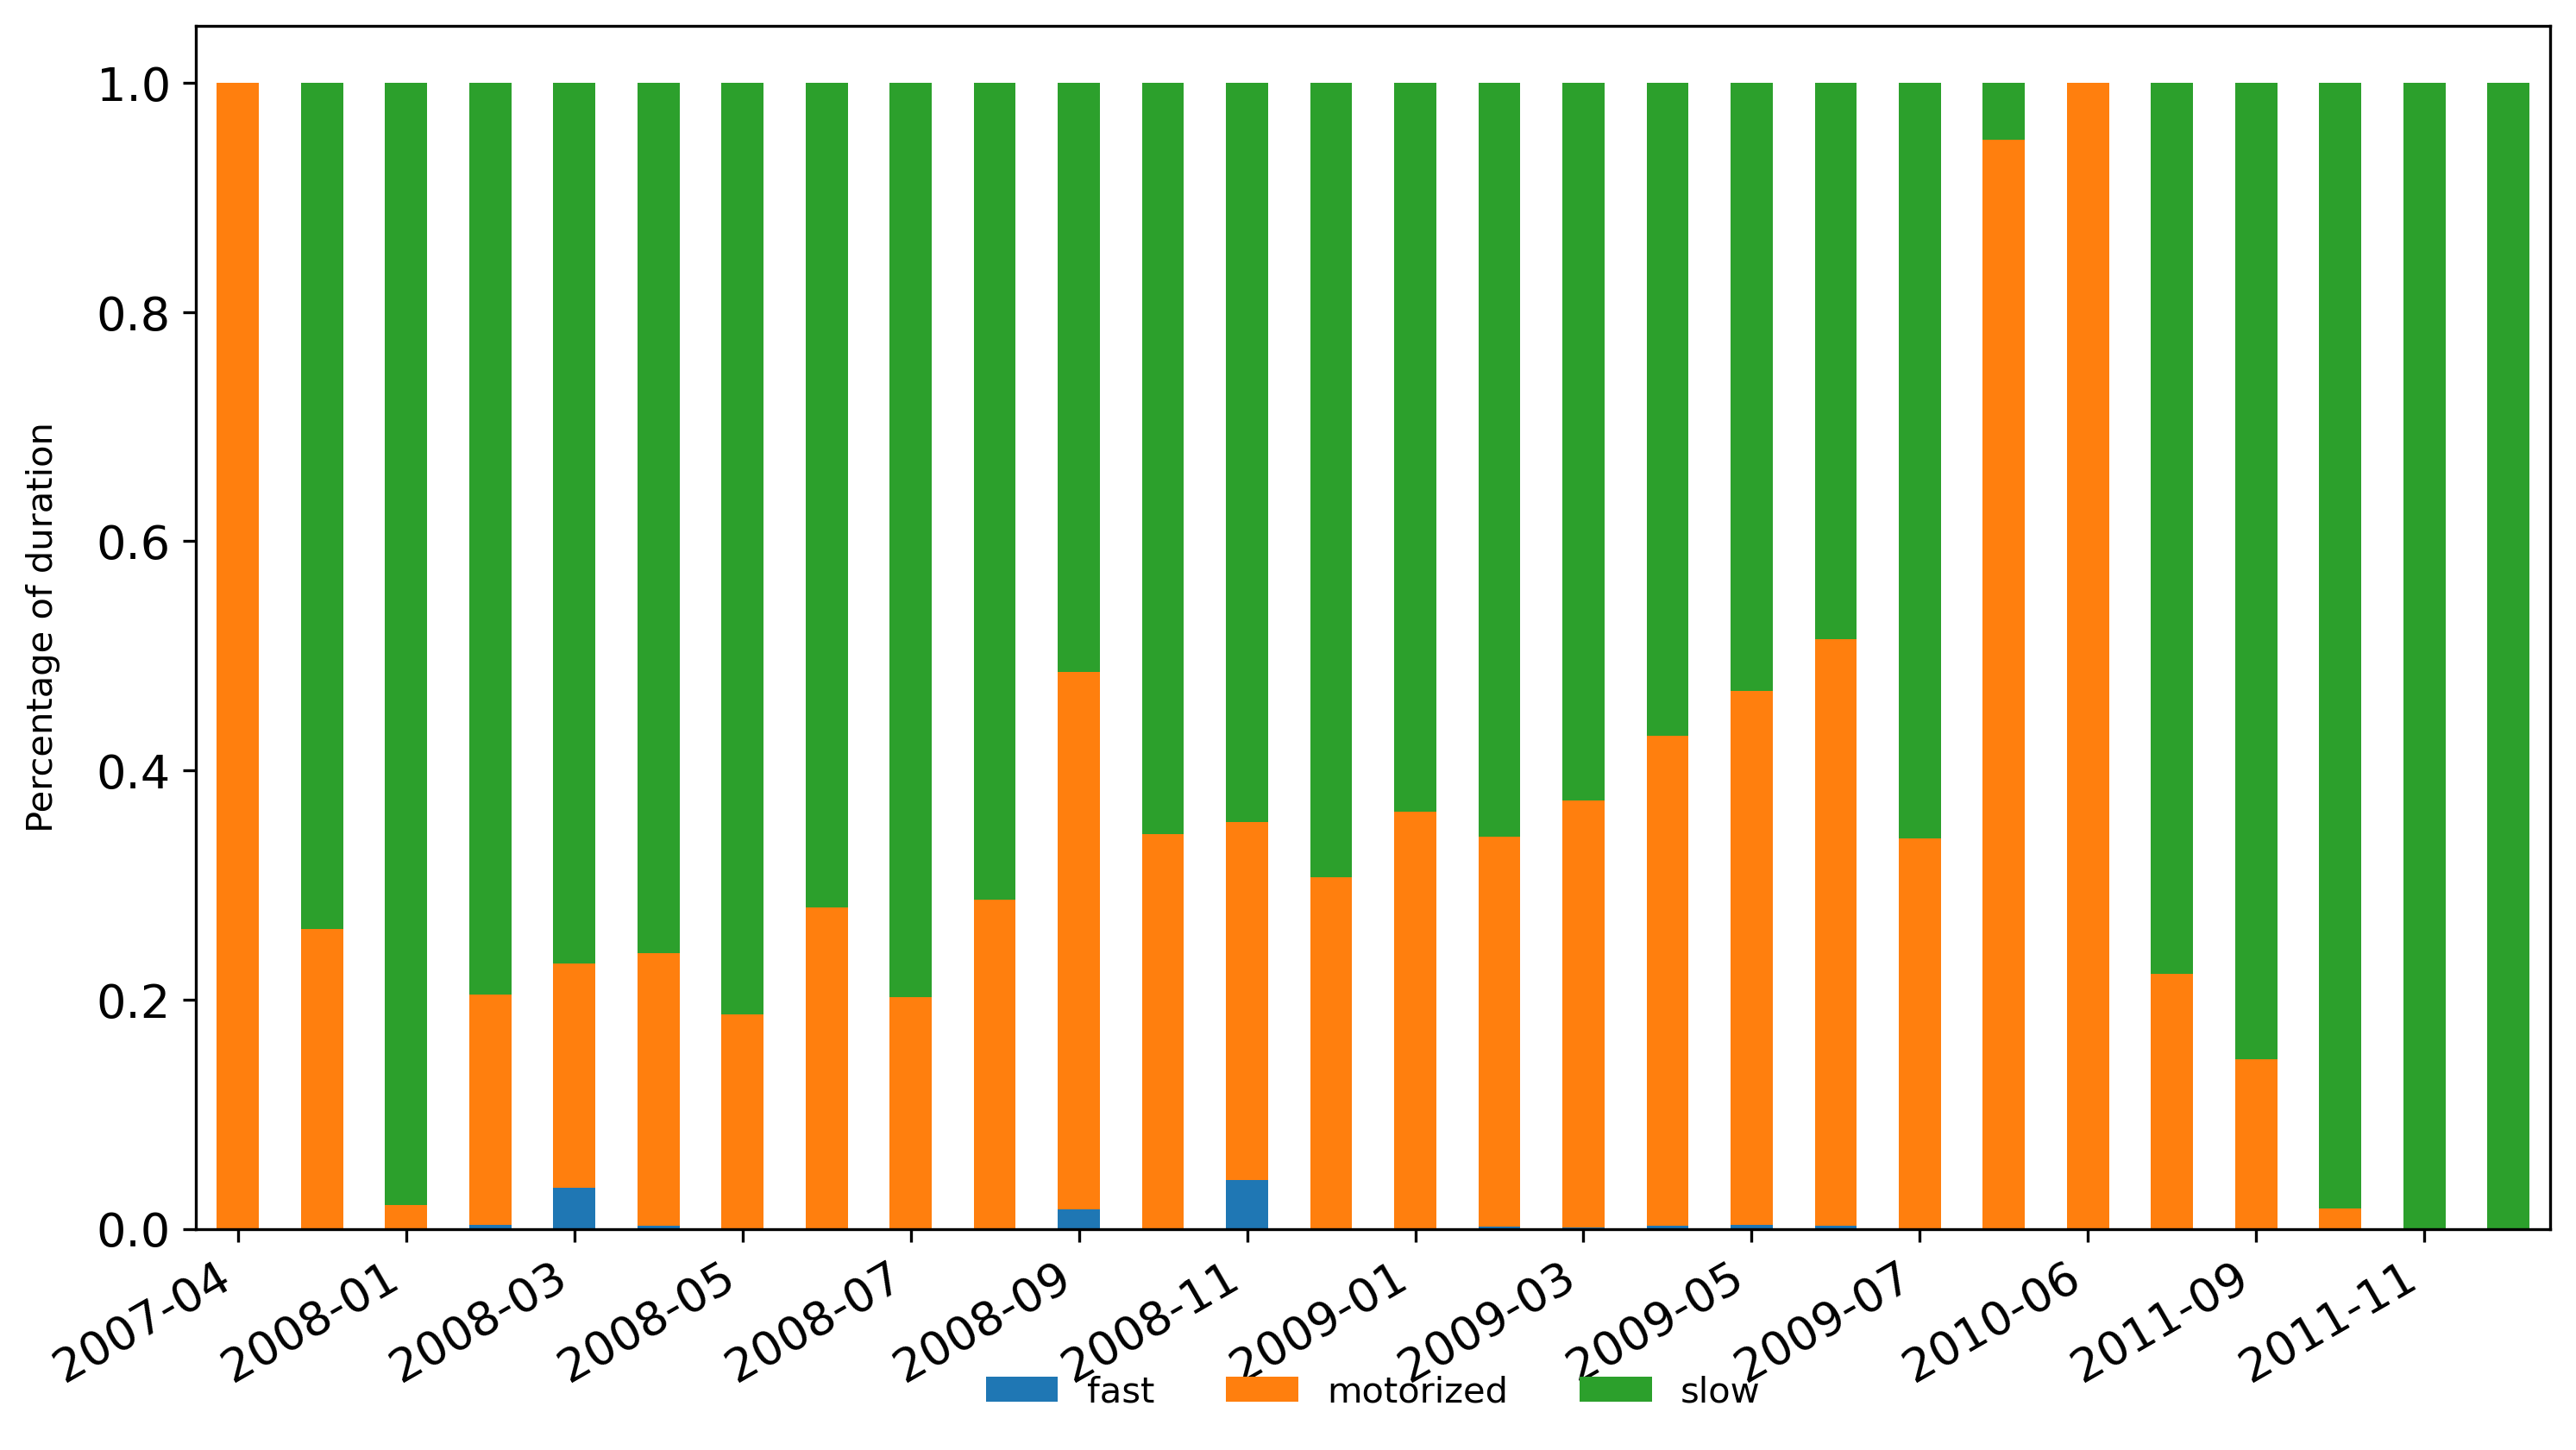

In [15]:
# duration
modal_split_duration = ti.analysis.calculate_modal_split(tpls, freq="M", metric="duration", per_user=False, norm=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax = ti.plot_modal_split(
    modal_split_duration,
    date_fmt_x_axis="%Y-%m",
    y_label="Percentage of duration",
    skip_xticks=2,
    n_col_legend=4,
    fig=fig,
    axis=ax,
    borderaxespad=2,
)
fig.autofmt_xdate()